In [1]:
%cd ..
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from scipy import stats
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
import seaborn as sns
import pandas as pd
%matplotlib inline

/auto/work/cetin/Projektpraktikum


In [2]:
def round(n, k):
    # function to round number 'n' up/down to nearest 'k'
    # use positive k to round up
    # use negative k to round down

    return n - n % k

In [3]:
file = uproot.open(
    "/work/cetin/Projektpraktikum/tracking_losses_ntuple_B_rad_length_beginVelo2endUT.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) &
                   (allcolumns.fromB)]
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) &
                  (allcolumns.fromB)]

electrons = allcolumns[(allcolumns.isElectron)
                       & (allcolumns.fromB)
                       & (allcolumns.eta <= 5.0)
                       & (allcolumns.eta >= 1.5)
                       & (np.abs(allcolumns.phi) < 3.142)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

40402 10099
49865


In [4]:
# variables

eta_a = ak.to_numpy(electrons["eta"])
phi_a = ak.to_numpy(electrons["phi"])
rad_length_frac_a = ak.to_numpy(electrons["rad_length_frac"])

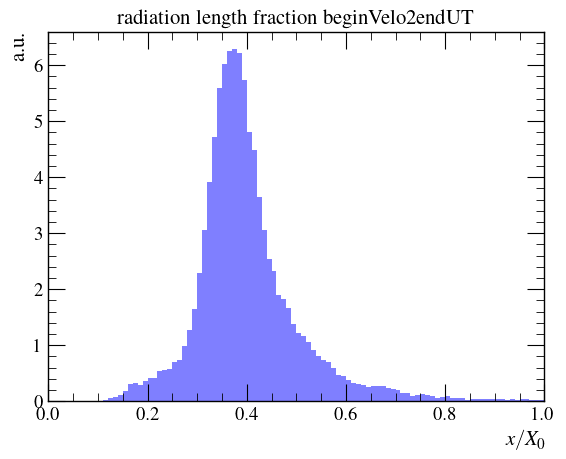

In [5]:
plt.hist(
    rad_length_frac_a,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction beginVelo2endUT")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")
plt.show()

In [6]:
df = pd.DataFrame({
    "phi": phi_a * 90.0 / np.pi,
    "eta": eta_a * 2.0,
    "rad_length_frac": rad_length_frac_a,
})
df = df.round({"phi": 0, "eta": 1, "rad_length_frac": 4})

In [7]:
df_pivoted = df.pivot_table(
    index="eta",
    columns="phi",
    values="rad_length_frac",
    margins=False,
    # fill_value=0,
)

In [8]:
df_pivoted

phi    -90.0   -89.0   -88.0   -87.0   -86.0    -85.0    -84.0    -83.0  \
eta                                                                       
3.1      NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN   
3.2      NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN   
3.3      NaN  1.2679     NaN  1.2759     NaN      NaN  1.87600      NaN   
3.4      NaN     NaN     NaN  1.2055  0.5502  0.28410  1.89590      NaN   
3.5      NaN  0.8370  0.6883  0.5597     NaN  1.30930      NaN  0.40660   
...      ...     ...     ...     ...     ...      ...      ...      ...   
9.6      NaN  0.1595  0.1948  0.2811  0.2285      NaN  0.34385  0.16810   
9.7      NaN     NaN     NaN  0.1688  0.1762  0.17905  0.16470  0.17470   
9.8   0.1703  0.1920  0.1787  0.1725  0.1707      NaN  0.16860  0.26055   
9.9      NaN  0.1831  0.1671  0.1485     NaN  0.17920  0.41690  0.17350   
10.0     NaN  0.2501     NaN  0.1900     NaN  0.23640      NaN      NaN   

phi      -82.0   -81.0  ...    81.0    82.0    83.0     84.0    85.0    86.0  \
eta                     ...                                                    
3.1        NaN     NaN  ...     NaN     NaN     NaN      NaN     NaN     NaN   
3.2        NaN     NaN  ...     NaN     NaN     NaN      NaN     NaN     NaN   
3.3   0.516900     NaN  ...  0.5076     NaN     NaN      NaN     NaN     NaN   
3.4   0.673400  0.2915  ...     NaN     NaN     NaN  0.52245  1.2931  1.2685   
3.5   1.724750     NaN  ...  0.3628  0.5306     NaN  0.56120     NaN  1.1481   
...        ...     ...  ...     ...     ...     ...      ...     ...     ...   
9.6        NaN  0.3408  ...     NaN  0.1605  0.3835  0.35830  0.2229     NaN   
9.7        NaN     NaN  ...  0.2906     NaN     NaN  0.23890  0.1618  0.1730   
9.8   0.231933     NaN  ...     NaN  0.1747     NaN  0.21850     NaN     NaN   
9.9   0.284200     NaN  ...  0.3746  0.2385  0.1257      NaN  0.4171     NaN   
10.0       NaN     NaN  ...     NaN  0.1828  0.2026  0.11630     NaN     NaN   

phi      87.0     88.0    89.0   90.0  
eta                                    
3.1       NaN      NaN     NaN    NaN  
3.2       NaN      NaN     NaN    NaN  
3.3       NaN      NaN     NaN    NaN  
3.4   0.26290      NaN  0.5286    NaN  
3.5   1.13330      NaN  0.4898    NaN  
...       ...      ...     ...    ...  
9.6   0.20530  0.25955  0.1618    NaN  
9.7       NaN  0.17520     NaN    NaN  
9.8   0.17465  0.14510  0.1860    NaN  
9.9       NaN  0.16620  0.1656    NaN  
10.0      NaN      NaN  0.1526    NaN  

[70 rows x 181 columns]

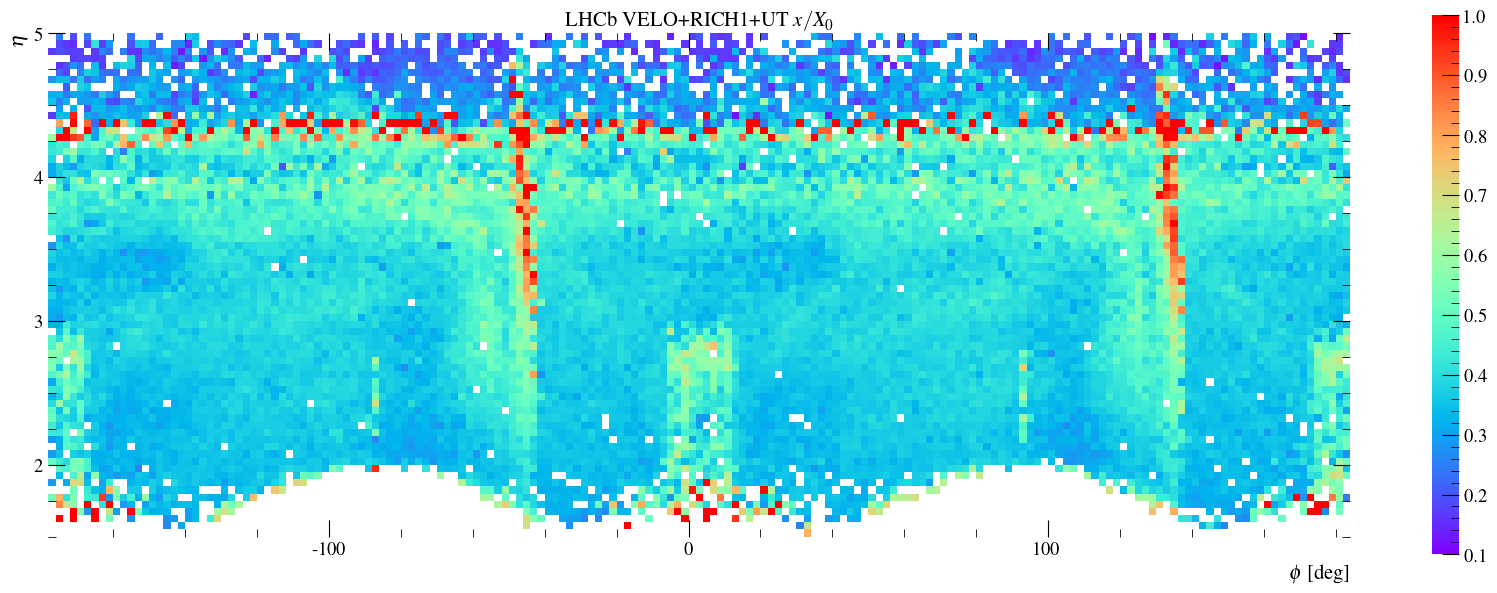

In [18]:
fig = plt.figure(figsize=(21, 7))
ax = sns.heatmap(
    df_pivoted,
    robust=True,
    square=True,
    cmap=colormaps["rainbow"],
    xticklabels=False,
    yticklabels=False,
    vmax=1,
    vmin=0.1,
)
# ax.set_yticks([5, 15, 25, 35], [2, 3, 4, 5])
ax.set_yticks([10, 30, 50, 70], [2, 3, 4, 5])
ax.set_xticks([39, 89, 139],
              [-100, 0, 100])  # ([79, 179, 279], [-100, 0, 100])
ax.set_xlabel(f"$\phi$ [deg]")
ax.set_ylabel(f"$\eta$")

# ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_title("LHCb VELO+RICH1+UT $x/X_0$")
plt.show()